In [1]:
import pandas as pd
df = pd.read_csv('Data/Stroke.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
print("Raw Counts")
print(df['stroke'].value_counts())
print()
print('Percentages')
print(df['stroke'].value_counts(normalize=True))

Raw Counts
0    4861
1     249
Name: stroke, dtype: int64

Percentages
0    0.951272
1    0.048728
Name: stroke, dtype: float64


<AxesSubplot:xlabel='stroke', ylabel='count'>

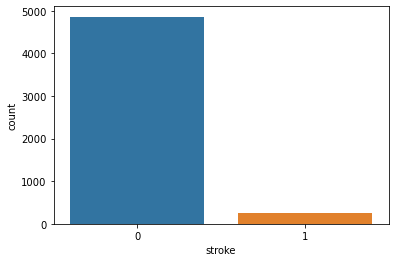

In [4]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.countplot(df['stroke'])

In [5]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
df['bmi'] = df['bmi'].fillna(df.bmi.mean())
df['bmi'] = df['bmi'].round(decimals=1)
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [7]:
df.groupby('stroke').mean()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,,
0,36487.236371,41.971545,0.088871,0.047110,104.795513,28.825612
1,37115.068273,67.728193,0.265060,0.188755,132.544739,30.218876


In [8]:
"""The mean age of people with stroke is around 67 years, they more likely to have hypertension and heart disease, their average glucose level and bmi is higher"""

'The mean age of people with stroke is around 67 years, they more likely to have hypertension and heart disease, their average glucose level and bmi is higher'

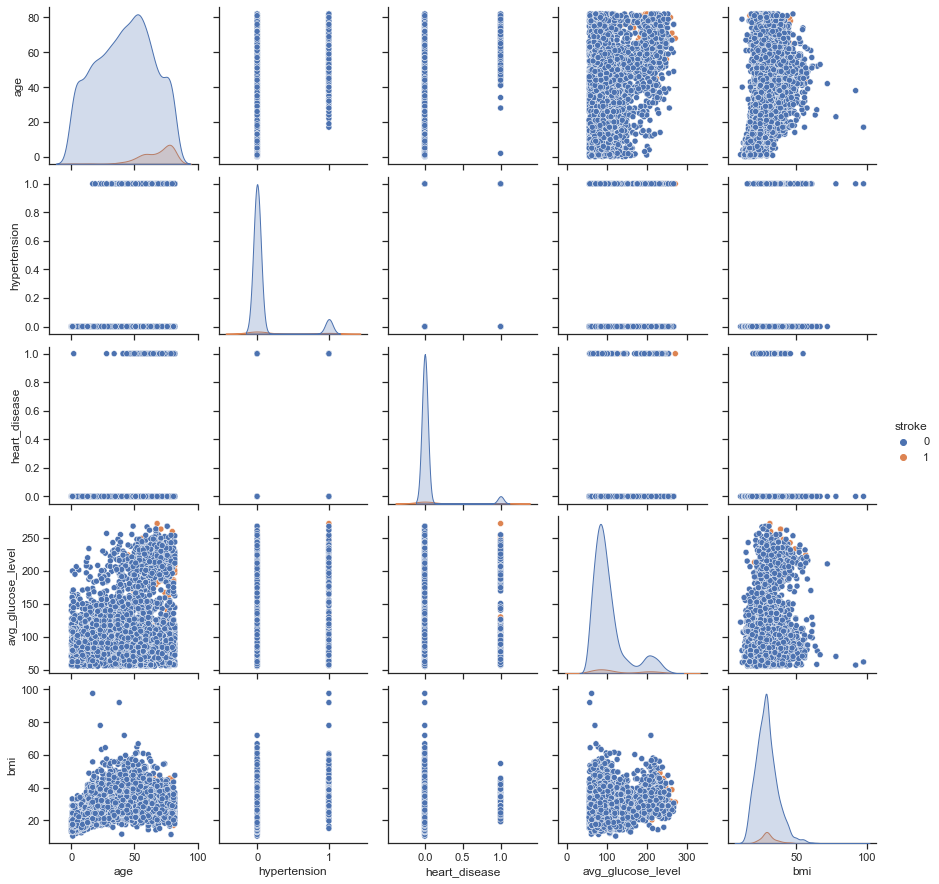

In [8]:
sns.set(style = 'ticks', color_codes=True)
sns.pairplot(data=df, hue='stroke',  
             vars=['age',
                   'hypertension',
                   'heart_disease',
                   'avg_glucose_level',
                   'bmi']);

Percentage of Stroke Occurence Based on Gender:
gender
Female    4.709419
Male      5.106383
Other     0.000000
Name: stroke, dtype: float64



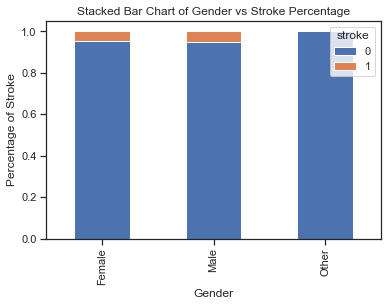

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Percentage of Stroke Occurence Based on Gender:")
print(df.groupby('gender')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.gender, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Gender vs Stroke Percentage')
plt.xlabel('Gender')
plt.ylabel('Percentage of Stroke')
plt.savefig('gender_vs_stroke')

Percentage of Stroke Occurence Based on Marital Status:
ever_married
No     1.650541
Yes    6.561288
Name: stroke, dtype: float64



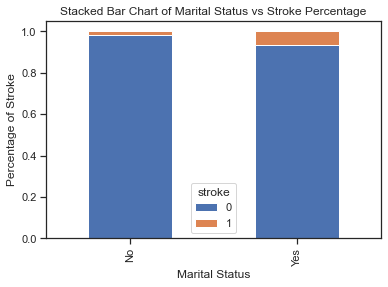

In [10]:
print("Percentage of Stroke Occurence Based on Marital Status:")
print(df.groupby('ever_married')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.ever_married, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Stroke Percentage')
plt.xlabel('Marital Status')
plt.ylabel('Percentage of Stroke')
plt.savefig('marriage_vs_stroke')

Percentage of Stroke Occurence Based on Work Type:
work_type
Govt_job         5.022831
Never_worked     0.000000
Private          5.094017
Self-employed    7.936508
children         0.291121
Name: stroke, dtype: float64



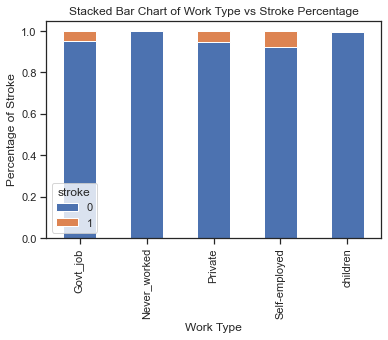

In [11]:
print("Percentage of Stroke Occurence Based on Work Type:")
print(df.groupby('work_type')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.work_type, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Work Type vs Stroke Percentage')
plt.xlabel('Work Type')
plt.ylabel('Percentage of Stroke')
plt.savefig('work_vs_stroke')

Percentage of Stroke Occurence Based on Residence Type:
Residence_type
Rural    4.534606
Urban    5.200308
Name: stroke, dtype: float64



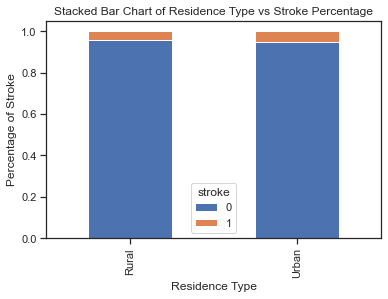

In [12]:
print("Percentage of Stroke Occurence Based on Residence Type:")
print(df.groupby('Residence_type')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.Residence_type, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Residence Type vs Stroke Percentage')
plt.xlabel('Residence Type')
plt.ylabel('Percentage of Stroke')
plt.savefig('residence_vs_stroke')

Percentage of Stroke Occurence Based on Smoking Status:
smoking_status
Unknown            3.044041
formerly smoked    7.909605
never smoked       4.756871
smokes             5.323194
Name: stroke, dtype: float64



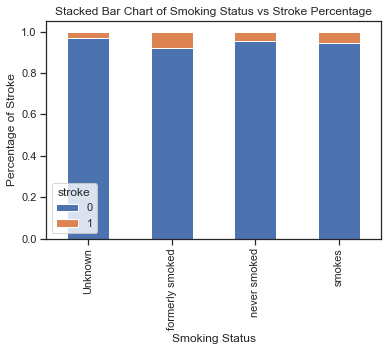

In [13]:
print("Percentage of Stroke Occurence Based on Smoking Status:")
print(df.groupby('smoking_status')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.smoking_status, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Smoking Status vs Stroke Percentage')
plt.xlabel('Smoking Status')
plt.ylabel('Percentage of Stroke')
plt.savefig('smoking_vs_stroke')

In [15]:
"""As seen from the abpve charts, the parameters that influence on whether a person will have a stroke are: marital status, work type and smoking status"""

'As seen from the abpve charts, the parameters that influence on whether a person will have a stroke are: marital status, work type and smoking status'

In [14]:
df['gender'] = df['gender'].replace({'Female': 0, 'Male': 1, 'Other': 2}).astype('int8')
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1}).astype('int8')
df['Residence_type'] = df['Residence_type'].replace({'Urban': 0, 'Rural': 1}).astype('int8')

In [15]:
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'])
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67.0,0,1,1,0,228.69,36.6,1,0,0,1,0,0,0,1,0,0
1,51676,0,61.0,0,0,1,1,202.21,28.9,1,0,0,0,1,0,0,0,1,0
2,31112,1,80.0,0,1,1,1,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,60182,0,49.0,0,0,1,0,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,1665,0,79.0,1,0,1,1,174.12,24.0,1,0,0,0,1,0,0,0,1,0


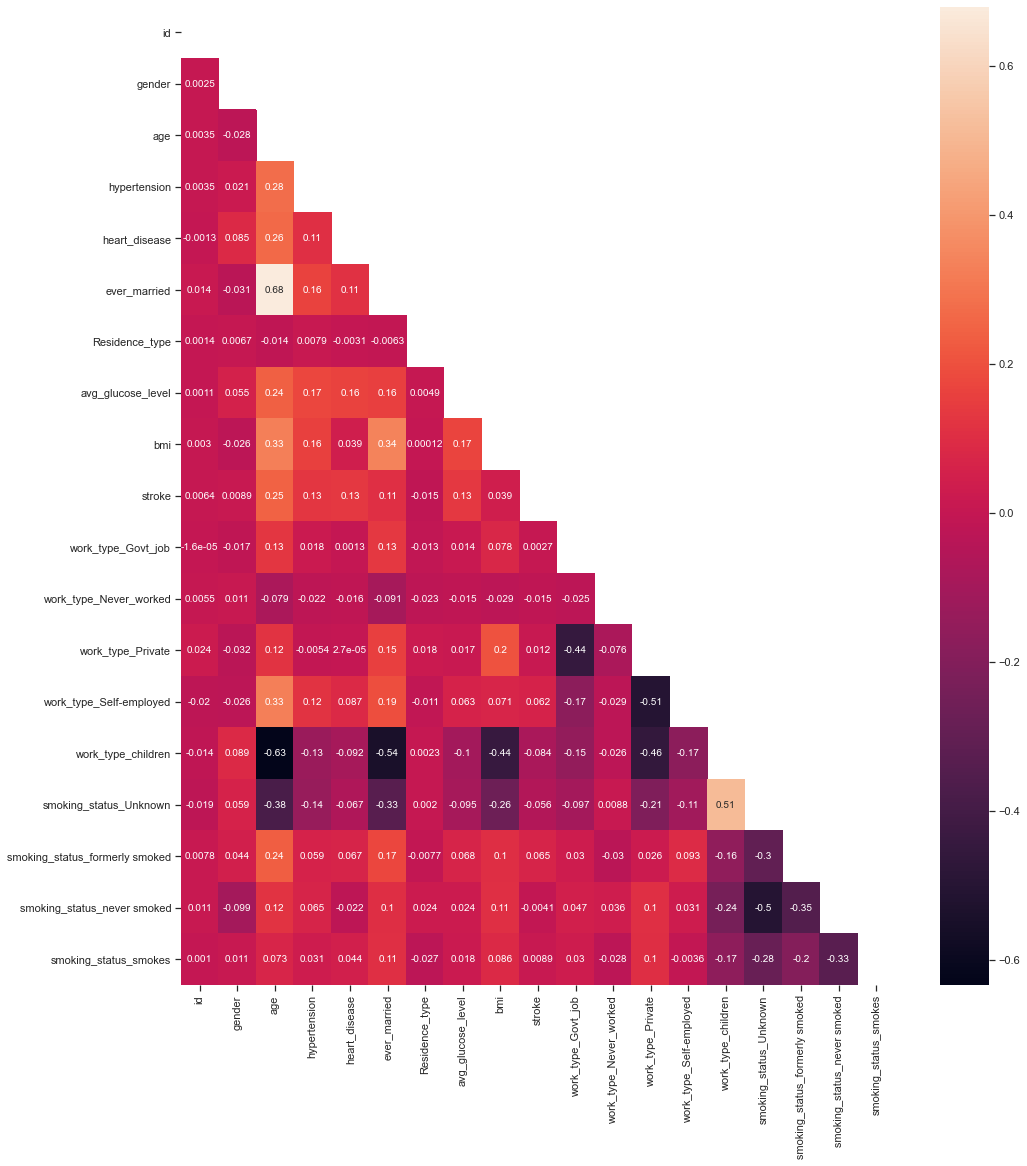

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
corr = df.corr()
fig, ax = plt.subplots(figsize = (16, 18))
sns.heatmap(data = corr, 
            mask = np.triu(np.ones_like(corr, dtype = bool)), 
            ax = ax, 
            annot = True);

In [17]:
y = df['stroke']
X = df.drop(columns=['id', 'stroke'], axis=1)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

0    3645
1     187
Name: stroke, dtype: int64 

 0    1216
1      62
Name: stroke, dtype: int64


In [19]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(y_train_resampled.value_counts())

1    3645
0    3645
Name: stroke, dtype: int64


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

baseline_model = LogisticRegression(random_state=42)
baseline_neg_log_loss_cv = -cross_val_score(
    baseline_model,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
baseline_neg_log_loss_cv.mean()

0.19649284511385898

In [21]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def print_metrics(labels, preds):
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [22]:
baseline_model.fit(X_train_resampled, y_train_resampled)
preds = baseline_model.predict(X_test)
print("Logistic Regression Baseline Model:")
print_metrics(y_test, preds)

Logistic Regression Baseline Model:
Accuracy Score: 0.905320813771518
Precision Score: 0.20202020202020202
Recall Score: 0.3225806451612903
F1 Score: 0.24844720496894407


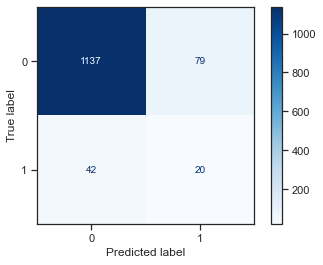

In [23]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(baseline_model, X_test, y_test, cmap = plt.cm.Blues);

In [24]:
features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'ever_married',
            'work_type_Self-employed', 'smoking_status_formerly smoked']
X_train_model = X_train_resampled[features]
X_test_model = X_test[features]

In [25]:
logreg_model = LogisticRegression(random_state=42)
logreg_neg_log_loss_cv = -cross_val_score(
    logreg_model,
    X_train_model,
    y_train_resampled,
    scoring='neg_log_loss')
logreg_neg_log_loss_cv.mean()

0.40847831441273036

In [26]:
logreg_model.fit(X_train_model, y_train_resampled)
preds = logreg_model.predict(X_test_model)
print("Logistic Regression Model with Features:")
print_metrics(y_test, preds)

Logistic Regression Model with Features:
Accuracy Score: 0.7652582159624414
Precision Score: 0.11363636363636363
Recall Score: 0.5645161290322581
F1 Score: 0.18918918918918917


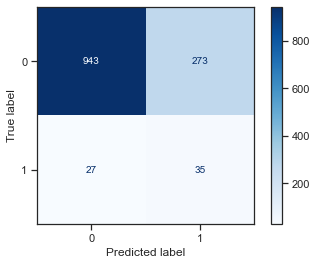

In [27]:
plot_confusion_matrix(logreg_model, X_test_model, y_test, cmap = plt.cm.Blues);

In [28]:
from sklearn.model_selection import GridSearchCV
logreg_best_model = LogisticRegression(random_state=42)
param_grid = {'penalty' : ['l1', 'l2', 'elasticnet'],
              'solver' : ['liblinear', 'saga']}
    
grid_search = GridSearchCV(estimator = logreg_best_model,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga']})

In [29]:
grid_search.best_params_

{'penalty': 'l2', 'solver': 'liblinear'}

In [30]:
logreg_best_model = LogisticRegression(random_state=42,
                                       penalty='l1',
                                       solver='liblinear')
logreg_best_neg_log_loss_cv = -cross_val_score(
    logreg_best_model,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
logreg_best_neg_log_loss_cv.mean()

0.1857680073601076

In [31]:
logreg_best_model.fit(X_train_resampled, y_train_resampled)
preds = logreg_best_model.predict(X_test)
print("Logistic Regression Best Model:")
print_metrics(y_test, preds)

Logistic Regression Best Model:
Accuracy Score: 0.917057902973396
Precision Score: 0.21794871794871795
Recall Score: 0.27419354838709675
F1 Score: 0.24285714285714285


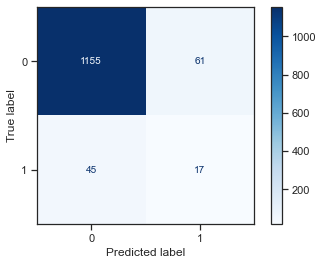

In [32]:
plot_confusion_matrix(logreg_best_model, X_test, y_test, cmap = plt.cm.Blues);

In [33]:
from sklearn.tree import DecisionTreeClassifier
dt_baseline_model = DecisionTreeClassifier(random_state=42)
dt_baseline_neg_log_loss_cv = -cross_val_score(
    dt_baseline_model,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
logreg_best_neg_log_loss_cv.mean()

0.1857680073601076

In [34]:
dt_baseline_model.fit(X_train_resampled, y_train_resampled)
preds = dt_baseline_model.predict(X_test)
print("Decision Tree Baseline Model:")
print_metrics(y_test, preds)

Decision Tree Baseline Model:
Accuracy Score: 0.9006259780907668
Precision Score: 0.14285714285714285
Recall Score: 0.20967741935483872
F1 Score: 0.16993464052287582


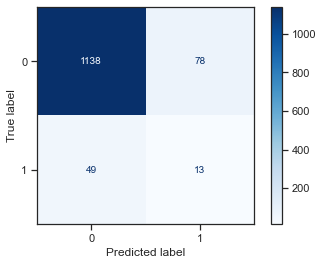

In [35]:
plot_confusion_matrix(dt_baseline_model, X_test, y_test, cmap = plt.cm.Blues);

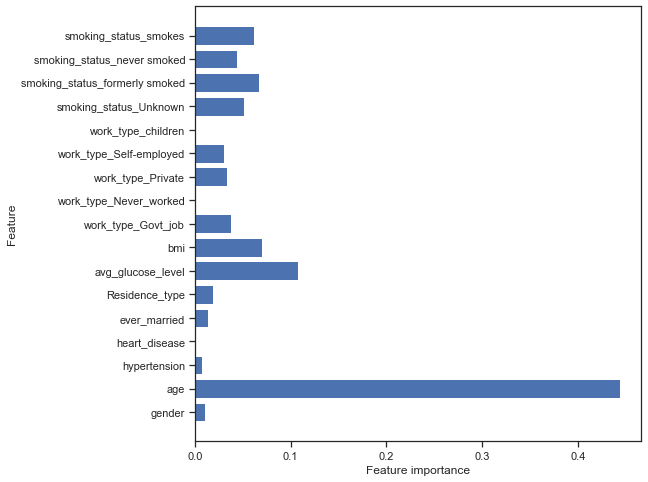

In [36]:
def plot_feature_importances(model):
    n_features = X_train_resampled.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train_resampled.columns.values)
    plt.xlabel("Feature importance")
    plt.ylabel('Feature')
    
plot_feature_importances(dt_baseline_model)

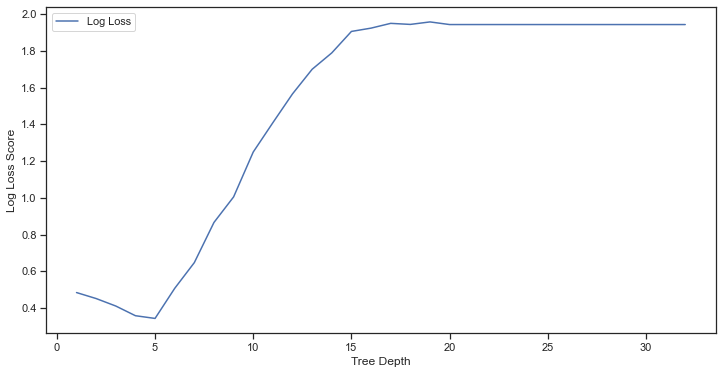

In [37]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
log_loss_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    dt_log_loss = cross_val_score(
        dt, 
        X_train_resampled,
        y_train_resampled,
        scoring='neg_log_loss')
    dtlog_loss = -(dt_log_loss.mean())
    log_loss_results.append(dtlog_loss)
    
plt.figure(figsize=(12,6))
plt.plot(max_depths, log_loss_results, label='Log Loss')
plt.ylabel('Log Loss Score')
plt.xlabel("Tree Depth")
plt.legend()
plt.show()

In [39]:
"""max depths of 5 is the best parameter"""

'max depths of 5 is the best parameter'

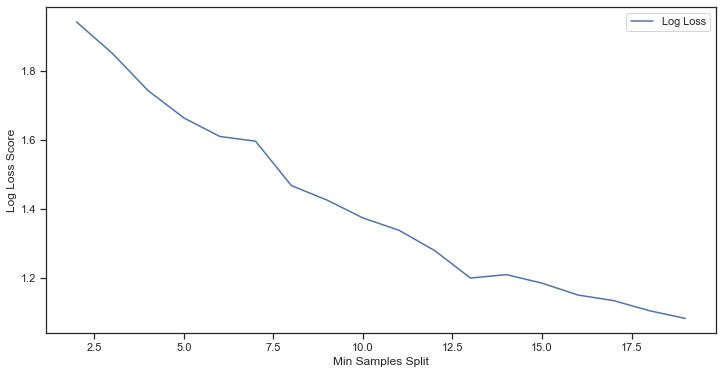

In [38]:
min_samples_splits = np.arange(2, 20)
log_loss_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(
        min_samples_split=int(min_samples_split),
        random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    dt_log_loss = cross_val_score(
        dt, 
        X_train_resampled,
        y_train_resampled,
        scoring='neg_log_loss')
    dtlog_loss = -(dt_log_loss.mean())
    log_loss_results.append(dtlog_loss)
    
plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, log_loss_results, label='Log Loss')
plt.ylabel('Log Loss Score')
plt.xlabel("Min Samples Split")
plt.legend()
plt.show()

In [41]:
"""min samples split of 13 is the best parameter"""

'min samples split of 13 is the best parameter'

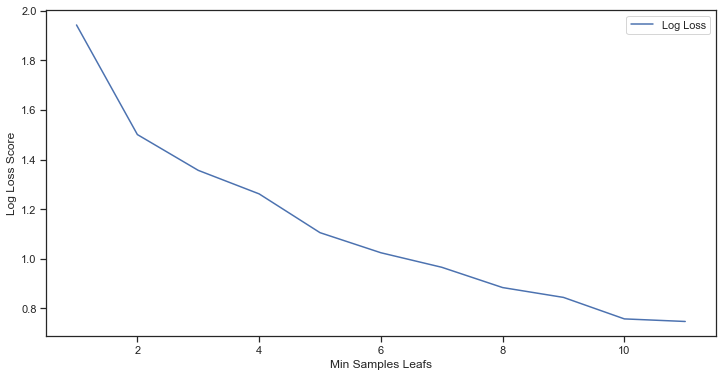

In [39]:
min_samples_leafs = np.arange(1, 12)
log_loss_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(
        min_samples_leaf=int(min_samples_leaf),
        random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    dt_log_loss = cross_val_score(
        dt, 
        X_train_resampled,
        y_train_resampled,
        scoring='neg_log_loss')
    dtlog_loss = -(dt_log_loss.mean())
    log_loss_results.append(dtlog_loss)
    
plt.figure(figsize=(12,6))
plt.plot(min_samples_leafs, log_loss_results, label='Log Loss')
plt.ylabel('Log Loss Score')
plt.xlabel("Min Samples Leafs")
plt.legend()
plt.show()

In [40]:
"""10 is the best parameter for min_samples_leafs"""

'10 is the best parameter for min_samples_leafs'

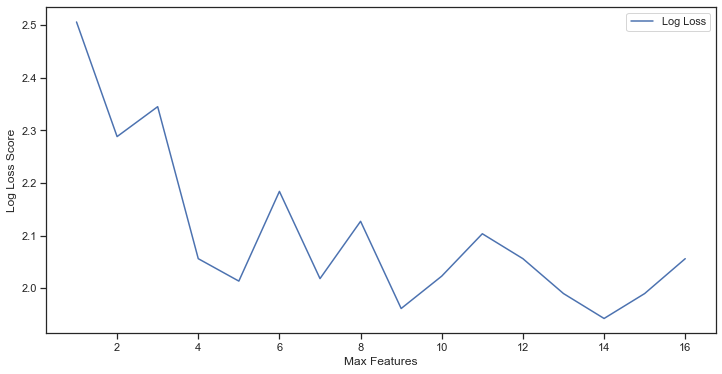

In [41]:
max_features = list(range(1, X_train_resampled.shape[1]))
log_loss_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(
        max_features=max_feature,
        random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    dt_log_loss = cross_val_score(
        dt, 
        X_train_resampled,
        y_train_resampled,
        scoring='neg_log_loss')
    dtlog_loss = -(dt_log_loss.mean())
    log_loss_results.append(dtlog_loss)
    
plt.figure(figsize=(12,6))
plt.plot(max_features, log_loss_results, label='Log Loss')
plt.ylabel('Log Loss Score')
plt.xlabel("Max Features")
plt.legend()
plt.show()

In [42]:
"""14 is the best parameter for max features"""

'14 is the best parameter for max features'

In [43]:
dt_first_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,
    min_samples_split=13,
    min_samples_leaf=10,
    max_features=14)
dt_first_neg_log_loss_cv = -cross_val_score(
    dt_first_model,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
dt_first_neg_log_loss_cv.mean()

0.32884526311083045

In [44]:
dt_first_model.fit(X_train_resampled, y_train_resampled)
preds = dt_first_model.predict(X_test)
print("Decision Tree First Model:")
print_metrics(y_test, preds)

Decision Tree First Model:
Accuracy Score: 0.837245696400626
Precision Score: 0.16818181818181818
Recall Score: 0.5967741935483871
F1 Score: 0.2624113475177305


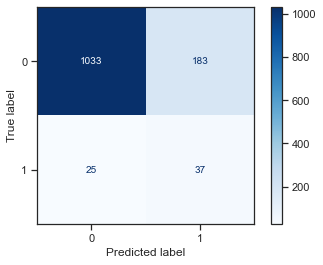

In [45]:
plot_confusion_matrix(dt_first_model, X_test, y_test, cmap = plt.cm.Blues);

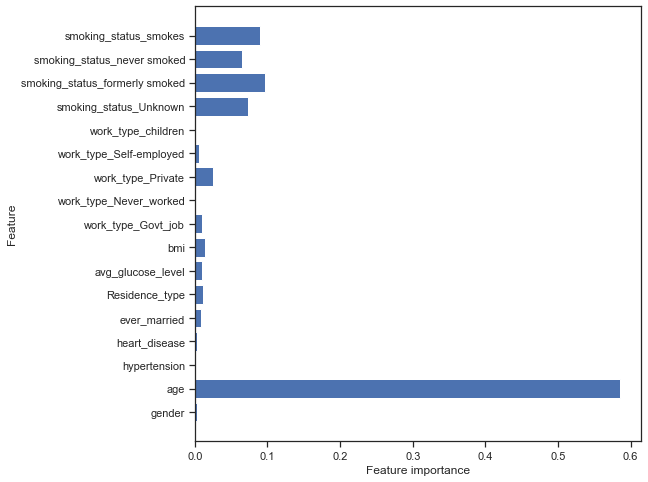

In [46]:
plot_feature_importances(dt_first_model)

Best Models so Far:

|                   | Log Loss | Accuracy | Precision | Recall | F1 Score |
|-------------------|----------|----------|-----------|--------|----------|
| Logreg Best Model | 0.181    | 0.927    | 0.262     | 0.274  | 0.268    |
| DT Baseline Model | 0.181    | 0.900    | 0.116     | 0.161  | 0.135    |

In [72]:
from sklearn.ensemble import BaggingClassifier
bagged_tree_baseline = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100)
bagged_tree_baseline_neg_log_loss_cv = -cross_val_score(
    bagged_tree_baseline,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
bagged_tree_baseline_neg_log_loss_cv.mean()

0.16312238930952594

In [73]:
bagged_tree_baseline.fit(X_train_resampled, y_train_resampled)
preds = bagged_tree_baseline.predict(X_test)
print("Bagged Tree Baseline Model:")
print_metrics(y_test, preds)

Bagged Tree Baseline Model:
Accuracy Score: 0.9264475743348983
Precision Score: 0.13636363636363635
Recall Score: 0.0967741935483871
F1 Score: 0.11320754716981131


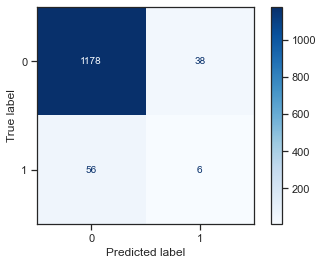

In [75]:
plot_confusion_matrix(bagged_tree_baseline, X_test, y_test, cmap = plt.cm.Blues);

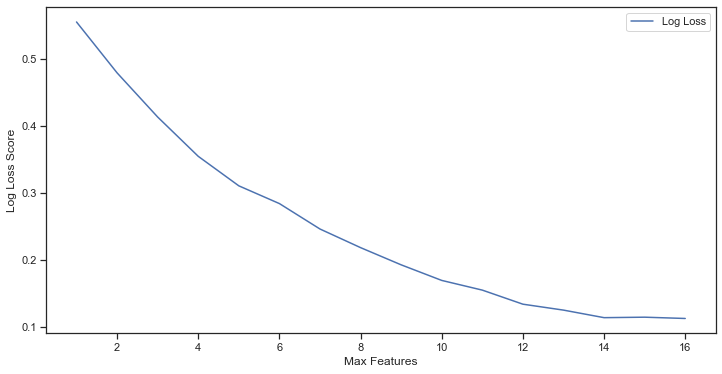

In [77]:
max_features = list(range(1, X_train_resampled.shape[1]))
log_loss_results = []
for max_feature in max_features:
    bagged_best = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                                    n_estimators=100,
                                    max_features=max_feature)
    bagged_best.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    bagged_log_loss = cross_val_score(
        bagged_best, 
        X_train_resampled,
        y_train_resampled,
        scoring='neg_log_loss')
    baggedlog_loss = -(bagged_log_loss.mean())
    log_loss_results.append(baggedlog_loss)
    
plt.figure(figsize=(12,6))
plt.plot(max_features, log_loss_results, label='Log Loss')
plt.ylabel('Log Loss Score')
plt.xlabel("Max Features")
plt.legend()
plt.show()

In [84]:
bagged_tree_tuned = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100, max_features=14)
bagged_tree_tuned_neg_log_loss_cv = -cross_val_score(
    bagged_tree_tuned,
    X_train_resampled,
    y_train_resampled,
    scoring='neg_log_loss')
bagged_tree_tuned_neg_log_loss_cv.mean()

0.11363077593772686

In [85]:
bagged_tree_tuned.fit(X_train_resampled, y_train_resampled)
preds = bagged_tree_tuned.predict(X_test)
print("Bagged Tree Tuned Model:")
print_metrics(y_test, preds)

Bagged Tree Tuned Model:
Accuracy Score: 0.9374021909233177
Precision Score: 0.125
Recall Score: 0.04838709677419355
F1 Score: 0.06976744186046512


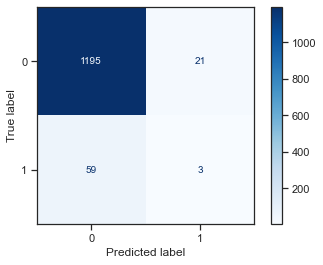

In [86]:
plot_confusion_matrix(bagged_tree_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [ ]:
bagged_tree_best = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100)
param_grid = {'n_estimators' : ['l1', 'l2', 'elasticnet'],
              'solver' : ['liblinear', 'saga']}
    
grid_search = GridSearchCV(estimator = logreg_best_model,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

In [69]:
knn_baseline_model.fit(X_train_scaled, y_train)
knn_preds = knn_baseline_model.predict(X_test_scaled)
print("KNN Baseline Model")
print_metrics(y_test, knn_preds)

KNN Baseline Model
Accuracy Score: 0.94679186228482
Precision Score: 0.125
Recall Score: 0.016129032258064516


In [85]:
knn_first_model = KNeighborsClassifier(n_neighbors=100)
knn_first_log_loss = -cross_val_score(
    knn_first_model,
    X_train_scaled,
    y_train,
    scoring='neg_log_loss').mean()
knn_first_log_loss

0.1956280342956694

In [83]:
knn_second_model = KNeighborsClassifier(n_neighbors=200)
knn_second_log_loss = -cross_val_score(
    knn_second_model,
    X_train_scaled,
    y_train,
    scoring='neg_log_loss').mean()
knn_second_log_loss

0.17963303643794215

In [86]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=100, max_k=200):
    best_k = 0
    best_score = 1.00
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        log_loss = -cross_val_score(
            knn,
            X_train,
            y_train, 
            scoring='neg_log_loss').mean()
        if log_loss < best_score:
            best_k = k
            best_score = log_loss
    print("Best Value for k: {}".format(best_k))
    print("Log Loss: {}".format(best_score))

In [87]:
find_best_k(X_train_scaled, y_train, X_test_scaled, y_test)

Best Value for k: 144
Log Loss: 0.17923810210065388


In [88]:
knn_best_model = KNeighborsClassifier(n_neighbors=144)
knn_best_log_loss = -cross_val_score(
    knn_best_model,
    X_train_scaled,
    y_train,
    scoring='neg_log_loss').mean()
print(knn_second_log_loss)
knn_best_model.fit(X_train_scaled, y_train)
preds = knn_best_model.predict(X_test_scaled)
print_metrics(y_test, preds)

0.17963303643794215
Accuracy Score: 0.9514866979655712
Precision Score: 0.0
Recall Score: 0.0
